# Introduction

The purpose of this notebook is to provide a more *user-friendly* experience to creating a **fast ice** dataset from simulated/modelled sea ice from [CICE](https://cice-consortium-cice.readthedocs.io/en/cice6.4.1/) (or [CICE github](https://github.com/CICE-Consortium/CICE)).

+ **NOTE 1**: The notebook requires some basic knowledge of Python3+ and Jupyter, as well as access to an HPC or a local system that uses ``PBS`` job queueing. If you cannot meet these requirements you will likely struggle to reproduce this workflow.

+ **NOTE 2**: The notebook presently assumes the user is a member of the Gadi project ``xp65`` which has a well maintained *conda* environment. This notebook is intended to be run with this basic ``PBS`` configuration ``PBS -l storage=gdata/gv90+gdata/hh5+gdata/ik11+gdata/jk72`` and then ``module use /g/data/hh5/public/modules; module load conda/analysis3-25.05``. If you have a local virtual environment that is equivalent to the libraries of ``conda/analysis3-25.05`` then this notebook should work for you.

+ **NOTE 3**: If you have a local directory of CICE generated results then you should edit ``../src/JSONs/afim_cice_analysis.json`` and the dictionary therein named ``D_dict``. The module/class ``SeaIceProcessor`` assumes you have simulations stored there-under with the relative-path naming convention of daily-averaged CICE model results stored as: ``[SIM_NAME]/history/daily/iceh.YYYY-MM-DD.nc``. ``SIM_NAME`` 

+ **NOTE 4**: If you do not have CICE generated **and** have access to __gadi__ projects: ``gv90``, ``jk72``, and ``xp65``; then this notebook should work for you in a *test* or *evaluation* mode. Provided that author's CICE simulations have not been altered.

# Clone the AFIM Repository

In [ ]:
import os, importlib
from pathlib import Path
# Set the directory where to clone;
# change D_repo to the directory of your choosing
AFIM_repo  = "https://github.com/dpath2o/AFIM.git"
D_repo_loc = Path.home() / "AFIM"
# use the os.system call to clone the repo if it does not already exist
if not D_repo_loc.exists():
    os.system(f"git clone {AFIM_repo} {D_repo_loc}")
else:
    print(f"AFIM repo previously cloned at: {D_repo_loc}")

## Syncing any possible changes of locally cloned ``AFIM`` repo with current kernel instance
If changes have been made to the cloned local copies of any of the AFIM classes: ``sea_ice_processor``, ``sea_ice_plotter`` or ``grounded_iceberg_processor``; **while** the kernel is running, then the following cell needs to be run in order for the kernel to *aware* of those changes. Else this cell can remain collapsed.

In [19]:
import sea_ice_processor
import sea_ice_plotter
import grounded_iceberg_processor
# Reload them if they were edited
importlib.reload(sea_ice_processor)
importlib.reload(sea_ice_plotter)
importlib.reload(grounded_iceberg_processor)
# Then (re)import the classes from the reloaded modules
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor

# Define Parameters
+ Next to each parameter below is a brief description of what the parameters *controls* within any/all of the ``AFIM`` modules.
+ If running this notebook in evaluation mode then this should not need any editing
+ Please do not **enable** ``overwrite_zarr`` **unless** you are working with your own version of CICE simulation results.

In [14]:
project_name    = "gv90"       # self-explanatory 
user_name       = "da1339"     # self-explanatory 
sim_name        = "gi-mid"     # unique name of CICE generated results
ispd_thresh     = 5e-4         # sea ice speed threshold; values below which will be considered fast ice
ispd_types      = ["ispd_BT"]  # sea ice speed re-gridding scheme; requires lengthy explanation and documenation regarding this is forthcoming
ice_types       = ["FI_BT"]    # "FI" = fast ice; "PI" = pack ice; suffix should be the same as those given for ispd_types (i.e. "_BT" and "_BT", or "_Ta" and "_Ta", etc.) 
start_date      = "1993-01-01" # date to start the processing/analysis; can be any valid date within the simulation period
end_date        = "1993-12-31" # date to cease the processing/analysis; can be any valid date within the simulation period that is greater (more recent) than the start date
daily           = True         # enable/disable thresholding sea ice speed of daily-averaged CICE results
rolling         = True         # enable/disable thresholding sea ice speed of N-day rolling-average of CICE results
roll_period     = 15           # days to compute the rolling average
overwrite_zarr  = False        # whether or not to overwrite existing zarr files that may exist for the sea ice speed threshold and ispd_type
                               # ONLY enable if you are confident you want to change your existing results!! 
overwrite_png   = False        # whether or not to overwrite existing graphic files that have been generated by this workflow
delete_original = False        # delete the original CICE netcdf and just keep the zarr; very handy in reducing disk storage
json_config     = None         # add your local edited version of ../src/JSONs/afim_cice_analysis.json; else load default
log_file        = f"/g/data/{project_name}/{user_name}/logs/process_fast_ice/{sim_name}/{start_date}_{end_date}_{ispd_thresh}.log"

# Intialise ``SeaIceProcessor`` class
This loads the JSON configuration file, starts a log file, as well as loads a grid and landmask file from ``GroundedIcebergProcessor`` class

In [15]:
from datetime import datetime
import sys
sys.path.insert(0, str(D_repo_loc / "src" / "AFIM" / "src"))
from sea_ice_processor import SeaIceProcessor
# Create processor instance
SI_proc = SeaIceProcessor(P_json              = json_config,
                          P_log               = log_file,
                          dt0_str             = start_date,
                          dtN_str             = end_date,
                          sim_name            = sim_name,
                          ice_speed_threshold = ispd_thresh)

2025-06-04 11:35:18,527 - INFO - hemisphere initialised: south
INFO:gi-mid:hemisphere initialised: south
2025-06-04 11:35:18,541 - INFO - Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
INFO:gi-mid:Ice speed threshold                        : 5.0e-04 m/s → 43.2 m/day
2025-06-04 11:35:18,545 - INFO - Median grid cell length below -60°: 10365.7 m
INFO:gi-mid:Median grid cell length below -60°: 10365.7 m
2025-06-04 11:35:18,547 - INFO - → Displacement                             = 0.42% of grid cell per day
INFO:gi-mid:→ Displacement                             = 0.42% of grid cell per day
2025-06-04 11:35:18,548 - INFO - → Days to fully traverse one grid cell     : 239.95 days
INFO:gi-mid:→ Days to fully traverse one grid cell     : 239.95 days


583 circumpolar grounded icebergs associated with gi-mid
66791608021.64 m^2 total circumpolar grounded iceberg area for gi-mid


# Convert daily-averaged CICE NetCDF files to monthly-concatenated daily-averaged zarr files 
+ Hugely beneficial for working with thousands of large NetCDF files
+ I have found this reduces disk-usage of daily-averaged CICE NetCDF (``iceh.*.nc`` history) files by **70%**
+ This only needs to be run once after new simulation results are obtained

In [16]:
SI_proc.daily_iceh_to_monthly_zarr(overwrite=overwrite_zarr, delete_original=delete_original)

2025-06-04 11:35:19,793 - INFO - *NO* CICE iceh.YYYY-MM-DD.nc files between the dates of 1993-01-01 and 1993-12-31 ... None being returned
INFO:gi-mid:*NO* CICE iceh.YYYY-MM-DD.nc files between the dates of 1993-01-01 and 1993-12-31 ... None being returned
2025-06-04 11:35:19,794 - INFO - No CICE files found. Noting further to do here.
INFO:gi-mid:No CICE files found. Noting further to do here.


# Fast Ice Masking (Daily and/or Rolling)
+ This is the backbone of processing workflow
+ Documentation for these methods is ongoing

In [17]:
if daily:
    DS_daily = SI_proc.process_daily_cice(ispd_type            = ispd_types,
                                          overwrite_zarr_group = overwrite_zarr)
if rolling:
    DS_roll = SI_proc.process_rolling_cice(mean_period          = roll_period,
                                           ispd_type            = ispd_types,
                                           overwrite_zarr_group = overwrite_zarr)

2025-06-04 11:35:21,135 - INFO - 📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-01.zarr
INFO:gi-mid:📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-01.zarr
2025-06-04 11:35:21,175 - INFO - 📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-02.zarr
INFO:gi-mid:📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-02.zarr
2025-06-04 11:35:21,206 - INFO - 📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-03.zarr
INFO:gi-mid:📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-03.zarr
2025-06-04 11:35:21,235 - INFO - 📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-04.zarr
INFO:gi-mid:📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-04.zarr
2025-06-04 11:35:21,265 - INFO - 📂 Loading monthly Zarr: /g/data/gv90/da1339/afim_output/gi-mid/zarr/iceh_1993-05.zarr
INFO:gi-mid:📂

# Compute fast ice metrics

2025-06-04 11:48:33,172 - INFO - /g/data/gv90/da1339/afim_output/gi-mid/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_mets.zarr exists and not overwriting--loading
INFO:gi-mid:/g/data/gv90/da1339/afim_output/gi-mid/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_mets.zarr exists and not overwriting--loading
2025-06-04 11:48:33,355 - INFO - /g/data/gv90/da1339/afim_output/gi-mid/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_roll_mets.zarr exists and not overwriting--loading
INFO:gi-mid:/g/data/gv90/da1339/afim_output/gi-mid/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_roll_mets.zarr exists and not overwriting--loading


583 circumpolar grounded icebergs associated with gi-mid
66791608021.64 m^2 total circumpolar grounded iceberg area for gi-mid
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/DML/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/WIO/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/EIO/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/Aus/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/VOL/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/AS/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/BS/FIP/ispd_thresh_5.0e-4/FI_BT/FIP_1993-1993.png exists and no

2025-06-04 11:48:33,529 - INFO - /g/data/gv90/da1339/afim_output/gi-mid/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr exists and not overwriting--loading
INFO:gi-mid:/g/data/gv90/da1339/afim_output/gi-mid/zarr/ispd_thresh_5.0e-4/metrics/FI_BT_bool_mets.zarr exists and not overwriting--loading


figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/DML/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/WIO/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/EIO/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/Aus/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/VOL/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/AS/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/BS/FIP/ispd_thresh_5.0e-4/FI_BT_roll/FIP_1993-1993.png exists and not overwriting
figure /g/data/gv90/da1339/GRAPHICAL/AFIM/gi-mid/WS/FIP/ispd_thresh_5.0e-4/FI_

/home/581/da1339/AFIM/src/AFIM/src/sea_ice_plotter.py:700: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


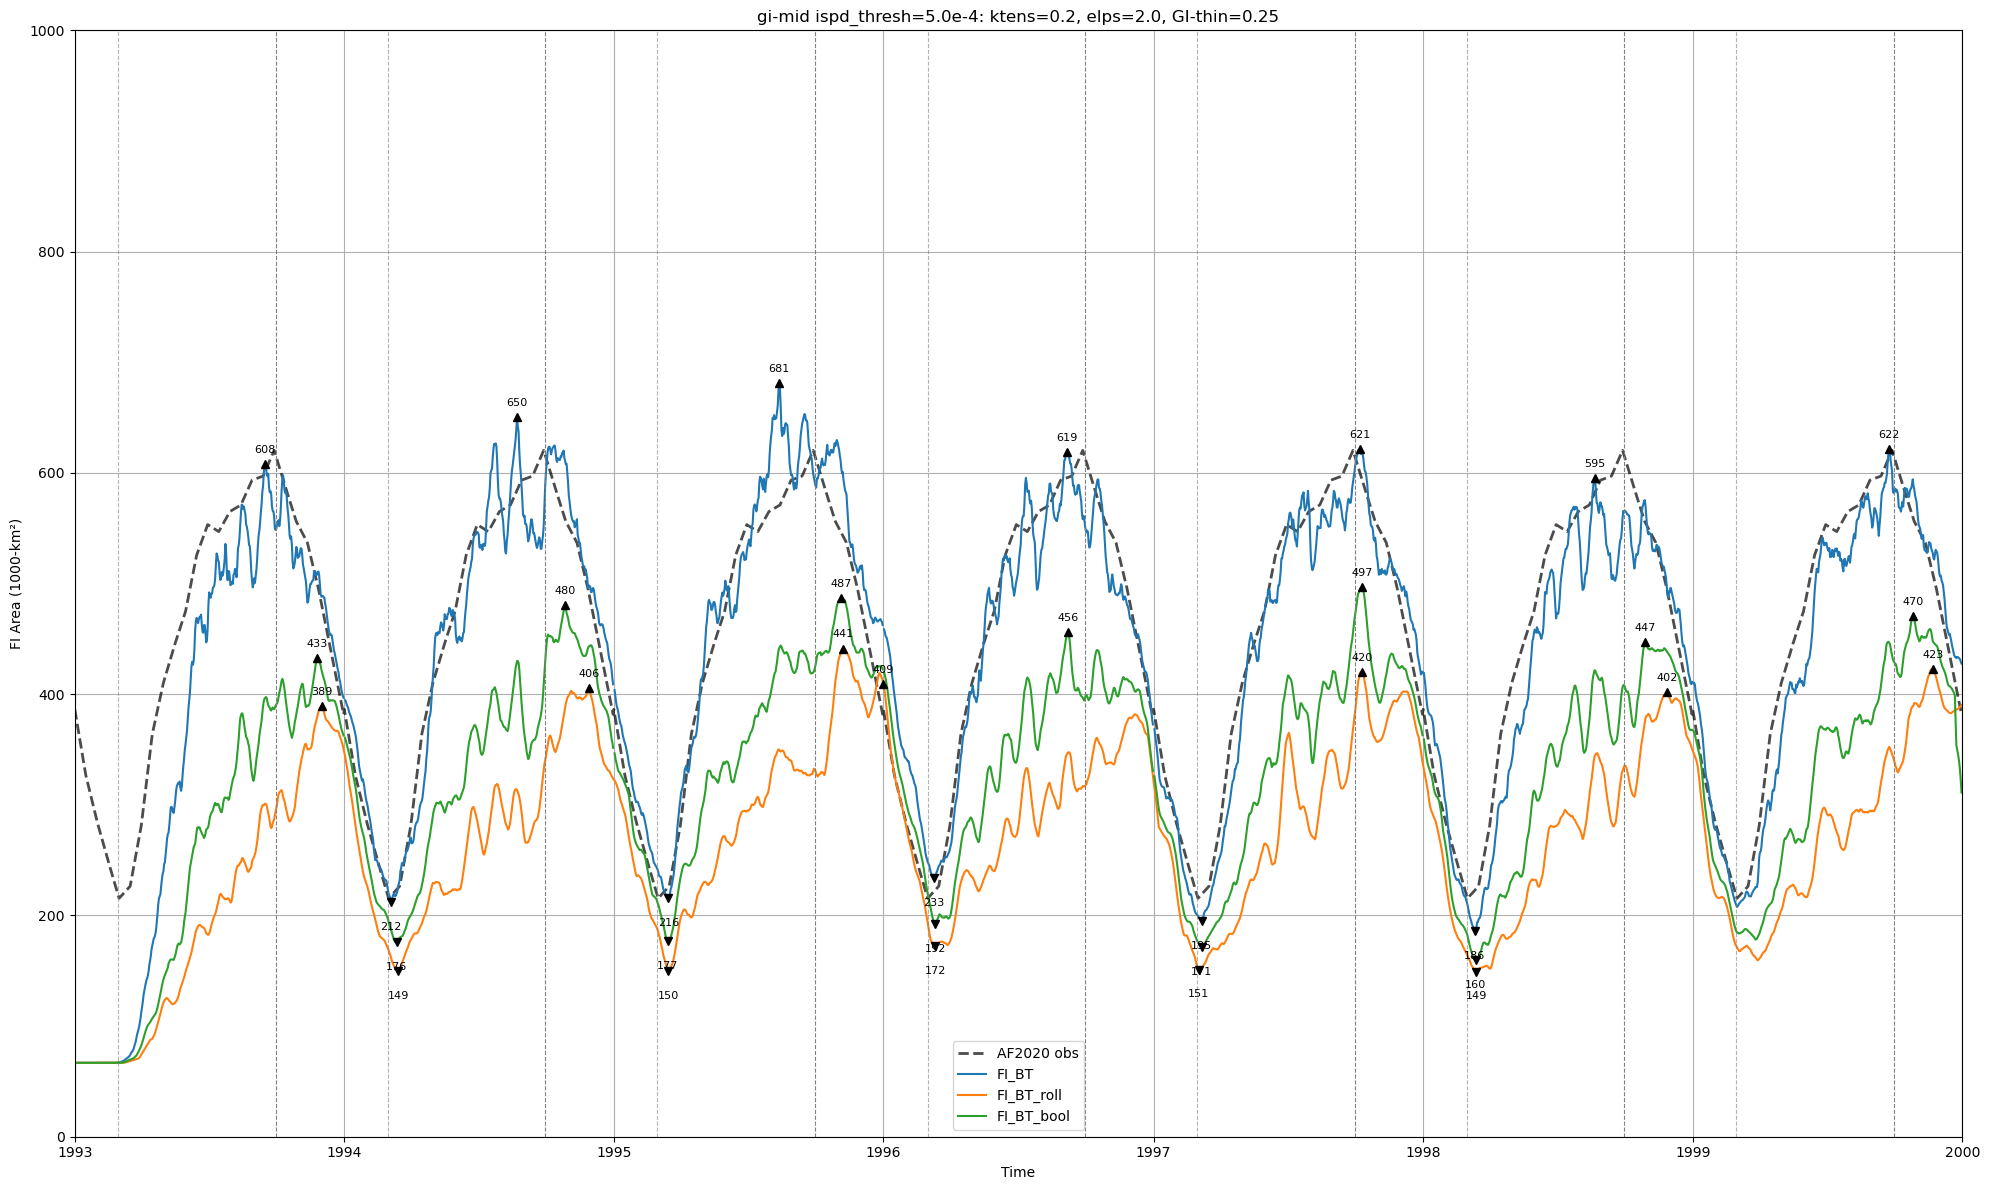

In [20]:
for itype in ice_types:
    SI_proc.sea_ice_metrics_wrapper(ice_type       = itype,
                                    overwrite_zarr = overwrite_zarr,
                                    overwrite_png  = overwrite_png)